# Modelado y entrenamiento con Red Neuronal Convolusional

## importar paquetes

In [16]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
import h5py
import seaborn as sns
from sklearn.model_selection import train_test_split
from skimage.transform import resize
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, AveragePooling2D 
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import OneHotEncoder, StandardScaler

#import seaborn as sns
import matplotlib.pyplot as plt


### definición de fucniones

In [17]:
# Función para transformar la imagen en un tensor
def load_image(image_name, image_dir):
    image_path = os.path.join(image_dir, image_name)
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [112, 112])  # Ajustar el tamaño si es necesario
    img = img / 255.0  # Normalizar
    return img.numpy()  # Convertir a numpy array para guardar



### Cargar Dataset

In [18]:
# Cargar el archivo
file_path = 'dataset_con_metadatos.h5'
with h5py.File(file_path, 'r') as f:
    images = np.array(f['images'])  
    sex = np.array(f['sex'])        
    age = np.array(f['age'])        
    #localization = np.array(f['localization'])  
    labels = np.array(f['classification'])  

#preparar dataset

In [19]:
# Normalizar el metadato edad
scaler = StandardScaler()
age_normalized = scaler.fit_transform(age.reshape(-1, 1))

# One-Hot Encoding para sexo y localización
encoder = OneHotEncoder(sparse_output=False)
sex_encoded = encoder.fit_transform(sex.reshape(-1, 1))
# localization_encoded = encoder.fit_transform(localization.reshape(-1, 1))

# Concatenar los metadatos
metadata = np.concatenate([age_normalized, sex_encoded], axis=1) #Se quitó la localización porque tiene mucahs más filas que los otros metadatos e imágenes

# A Dividir el dataset en entrenamiento y test (80% entrenamiento, 20% test)
imagenes_train, imagenes_test, etiquetas_train, etiquetas_test = train_test_split(
    images, labels, test_size=0.2, random_state=42 
)


### definir el modelo 

In [20]:
# modelo con mas cap
# modelo del notebook de los profes
model_cnn = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(112, 112, 3)),
    AveragePooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    AveragePooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='sigmoid')
])

model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.summary()


c:\Users\mvege\Documents\Marce\M1000IA - Nivel 4\DermAI\M1000IAN4\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 110, 110, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 55, 55, 32)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 53, 53, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 26, 26, 64)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 43264)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     5,537,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,557,570 (21.20 MB)

 Trainable params: 5,557,570 (21.20 MB)

 Non-trainable params: 0 (0.00 B)

### Entrenamiento

In [21]:
# agregarmos parametro para detener entrenamiento cuando empiece a sobreajustra
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_cnn = model_cnn.fit(
    imagenes_train, 
    etiquetas_train,
    epochs=20, 
    batch_size=20, 
    validation_data=(imagenes_test, etiquetas_test),
    callbacks=[early_stopping],
)


Epoch 1/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 49s 134ms/step - accuracy: 0.5465 - loss: 0.7106 - val_accuracy: 0.5234 - val_loss: 0.7498
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 26s 127ms/step - accuracy: 0.6285 - loss: 0.6179 - val_accuracy: 0.6567 - val_loss: 0.5482
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - accuracy: 0.7002 - loss: 0.5432 - val_accuracy: 0.7313 - val_loss: 0.4920
Epoch 4/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 24s 121ms/step - accuracy: 0.7082 - loss: 0.5285 - val_accuracy: 0.7065 - val_loss: 0.5218
Epoch 5/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - accuracy: 0.7368 - loss: 0.4957 - val_accuracy: 0.7284 - val_loss: 0.5072
Epoch 6/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 25s 123ms/step - accuracy: 0.7504 - loss: 0.4785 - val_accuracy: 0.7423 - val_loss: 0.4865
Epoch 7/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 25s 122ms/step - accuracy: 0.7478 - loss: 0.5025 - val_accuracy: 0.7502 - val_loss: 0.4760
Epoch 8/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 26s 127ms/step - accuracy: 0.7548 - loss: 0

#Visualización de resultados

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.7678 - loss: 0.4544
Accuracy del modelo CNN en el conjunto de prueba: 0.7502487301826477


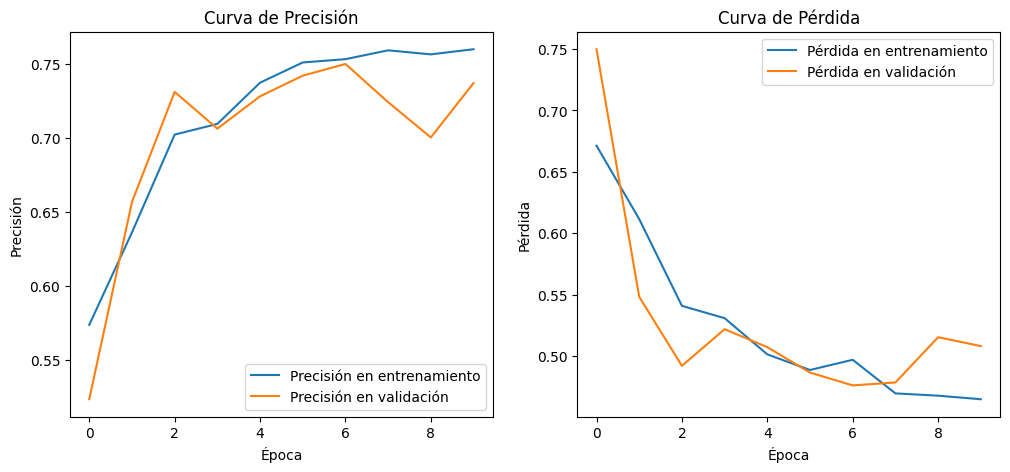

In [22]:
test_loss, test_acc = model_cnn.evaluate(imagenes_test, etiquetas_test)

print("Accuracy del modelo CNN en el conjunto de prueba:", test_acc)

# Evaluación del modelo

# 
# Gráficas de entrenamiento y validación
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history_cnn.history['val_accuracy'], label='Precisión en validación')
plt.title('Curva de Precisión')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history_cnn.history['val_loss'], label='Pérdida en validación')
plt.title('Curva de Pérdida')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       522
           1       0.72      0.77      0.75       483

    accuracy                           0.75      1005
   macro avg       0.75      0.75      0.75      1005
weighted avg       0.75      0.75      0.75      1005



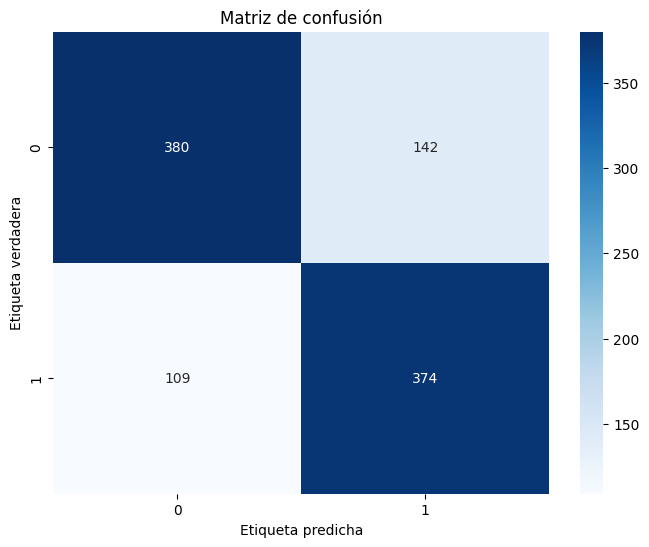

In [23]:
from sklearn.metrics import classification_report, confusion_matrix


# Suponiendo que ya tienes 'model_cnn' entrenado y las imágenes de prueba y etiquetas
predictions = model_cnn.predict(imagenes_test)

# Convertir predicciones a clases
predicted_classes = np.argmax(predictions, axis=1)

# Convertir etiquetas de prueba a formato unidimensional
true_classes = np.argmax(etiquetas_test, axis=1)

# Calcular y mostrar el informe de clasificación
print(classification_report(true_classes, predicted_classes))

# Calcular y mostrar la matriz de confusión
conf_matrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Etiqueta verdadera')
plt.xlabel('Etiqueta predicha')
plt.title('Matriz de confusión')
plt.show()




In [24]:
# guardar modelo
model_cnn.save('modelo_cnn.keras')